<a href="https://colab.research.google.com/github/kebabee/autoencoder-memory/blob/main/associative_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Associative memory in autoencoders

The Hopfield network (and especially the dense associative memory) provided associative memory in the neural network. Such a network learns the patterns themselves and does not learn the noise, yet is able to reproduce patterns with different types of noise or with only part of the pattern. Is this the only architecture at which it is not necessary to learn noise to correctly reproduce patterns?

## Case study

I will try to implement associative memory in autoencoder. The idea is simple:
* A simple autoencoder learns to reconstruct 1000 MNIST digits without any noise, pixel clipping, etc.
* After learning, in the autoencoder input I put digits with noise, halved, etc.
* I count the difference between noisy and original and between restored and original.

If the reconstructed digits are more similar to the originals than the noisy ones, it can be concluded that somehow the associative memory has been successfully implemented.

## First autoencoder

We have 5 layers: 784 neurons - 256 - 64 - 256 - 784. The autoencoder learns 1000 digits (100 for each one) with different number of epochs (from 1 to 201 every 10). The test set is different variations of "spoiled" digits. We have consecutively:
* 10% randomly picked pixels set to random float from 0.0 to 1.0 (original [0,255] is scaled to [0,1])
* 20% random pixels set to random float
* 30% random pixels set to random float
* 40% random pixels set to random float
* 50% random pixels set to random float

Loading MNIST and libraries:


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()

selected_digits = []
for digit in range(10):
  idx = np.where(y_train == digit)[0][:100]
  selected_digits.append(x_train[idx])

selected_digits = np.array(selected_digits).reshape(-1, 28, 28)
selected_digits = selected_digits.astype('float32') / 255.0 # rescale to [0,1]
selected_digits = selected_digits.reshape(-1, 784) # to vector

preparing spoiled digits:

In [2]:
import random

def add_noise(images, noise_factor):
    noisy_images = images.copy()
    n_pixels = int(noise_factor * images.shape[1])
    for img in noisy_images:
        noise_idx = np.random.choice(images.shape[1], n_pixels, replace=False)
        for i in range(n_pixels):
            img[noise_idx[i]] = random.uniform(0.0, 1.0)
    return noisy_images

# def cut_pixels(images, noise_factor):
#     noisy_images = images.copy()
#     n_pixels = int(noise_factor * images.shape[1])
#     for img in noisy_images:
#         noise_idx = np.arange(n_pixels)
#         img[noise_idx] = 0.5
#     return noisy_images

rand10_digits = add_noise(selected_digits, 0.1)
rand20_digits = add_noise(selected_digits, 0.2)
rand30_digits = add_noise(selected_digits, 0.3)
rand40_digits = add_noise(selected_digits, 0.4)
rand50_digits = add_noise(selected_digits, 0.5)
# first10_digits = cut_pixels(selected_digits, 0.1)
# first30_digits = cut_pixels(selected_digits, 0.3)
# first50_digits = cut_pixels(selected_digits, 0.5)

defining simple autoencoder:

In [3]:
input_img = Input(shape=(784,))
encoded = Dense(256, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

### Sample:
Autoecnoder learned digits for 100 epochs, it is tested for two selected test datasets.


Epoch 1/50
10/10 [==============================] - 4s 31ms/step - loss: 0.6032
Epoch 2/50
10/10 [==============================] - 0s 36ms/step - loss: 0.3306
Epoch 3/50
10/10 [==============================] - 0s 24ms/step - loss: 0.2771
Epoch 4/50
10/10 [==============================] - 0s 19ms/step - loss: 0.2571
Epoch 5/50
10/10 [==============================] - 0s 21ms/step - loss: 0.2430
Epoch 6/50
10/10 [==============================] - 0s 29ms/step - loss: 0.2288
Epoch 7/50
10/10 [==============================] - 0s 26ms/step - loss: 0.2126
Epoch 8/50
10/10 [==============================] - 0s 20ms/step - loss: 0.1979
Epoch 9/50
10/10 [==============================] - 0s 23ms/step - loss: 0.1869
Epoch 10/50
10/10 [==============================] - 0s 31ms/step - loss: 0.1788
Epoch 11/50
10/10 [==============================] - 0s 22ms/step - loss: 0.1722
Epoch 12/50
10/10 [==============================] - 0s 23ms/step - loss: 0.1662
Epoch 13/50
10/10 [==================

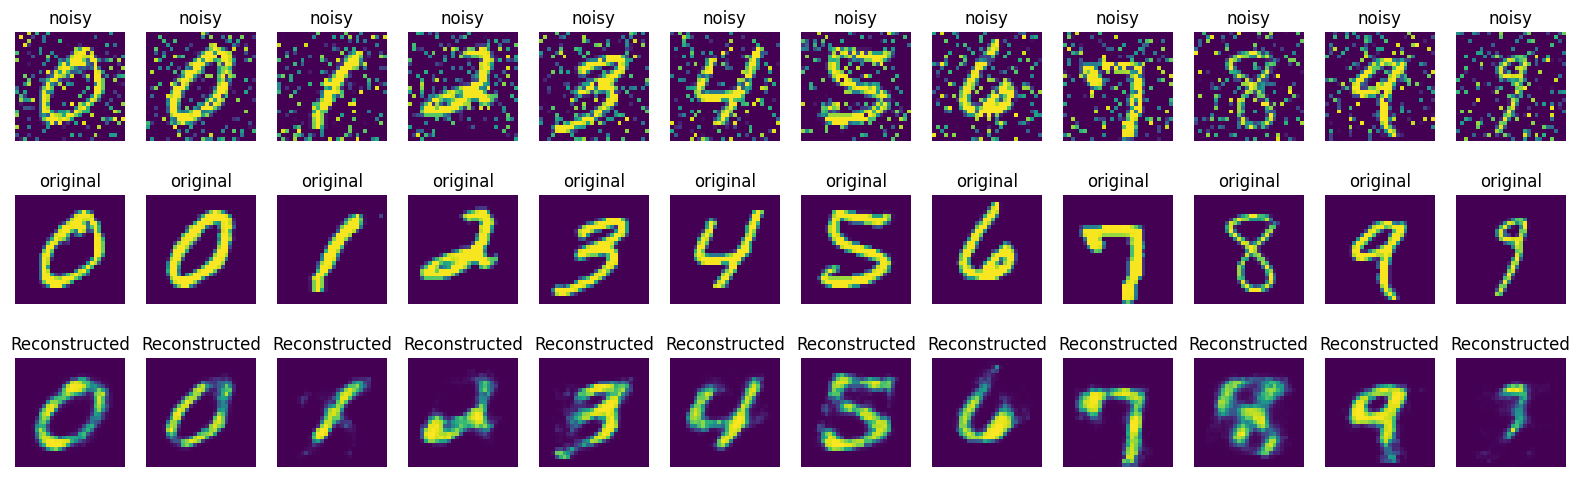

Mean difference between original and first 30% noised: 0.09566524624824524
Mean difference between original and reconstructed: 0.06234006956219673


In [4]:
autoencoder.fit(selected_digits, selected_digits, epochs=50, batch_size=100, shuffle=True)
#autoencoder.save('simple_autoencoder.h5')

def plot_images(original, noisy, reconstructed, n):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(noisy[90*i].reshape(28, 28))
        plt.title("noisy")
        plt.axis('off')

        # Display noisy
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(original[90*i].reshape(28, 28))
        plt.title("original")
        plt.axis('off')

        # Display reconstruction
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(reconstructed[90*i].reshape(28, 28))
        plt.title("Reconstructed")
        plt.axis('off')
    plt.show()

decoded_imgs = autoencoder.predict(rand20_digits)

plot_images(selected_digits, rand20_digits, decoded_imgs, n=12)

mean_diff_noisy_original = np.mean(np.abs(selected_digits - rand20_digits))
mean_diff_decoded_original = np.mean(np.abs(selected_digits - decoded_imgs))

print(f"Mean difference between original and first 30% noised: {mean_diff_noisy_original}")
print(f"Mean difference between original and reconstructed: {mean_diff_decoded_original}")

Just to check, how this autoencoder works with "predicting" originals?

32/32 [==============================] - 0s 3ms/step


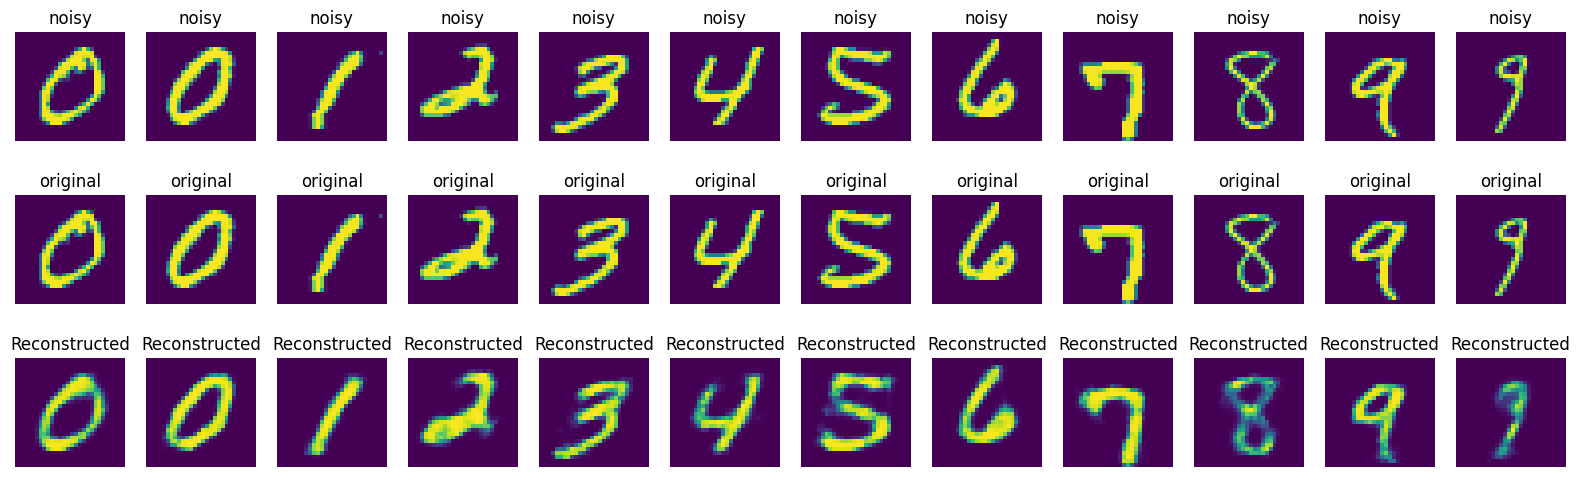

Mean difference between original and original xD: 0.0
Mean difference between original and reconstructed: 0.03451608493924141


In [5]:
decoded_imgs_3 = autoencoder.predict(selected_digits)

plot_images(selected_digits, selected_digits, decoded_imgs_3, n=12)

mean_diff_noisy_original_3 = np.mean(np.abs(selected_digits - selected_digits)) #duh
mean_diff_decoded_original_3 = np.mean(np.abs(selected_digits - decoded_imgs_3))

print(f"Mean difference between original and original xD: {mean_diff_noisy_original_3}")
print(f"Mean difference between original and reconstructed: {mean_diff_decoded_original_3}")

The digits returned by the autoencoder turned out to be slightly more similar to the originals than the noisy digits. I will run multiple autoencoders with different test datasets and epochs to investigate this relation in more details.

## Main experiment

I will record "factor of differences" as:
$$a=\frac{\text{Mean difference between original and decoded}}{\text{Mean difference between original and noised}}$$
with independent $a$ for every test dataset.

When $a<1$ it means that the reconstructed digits are more similar to the originals than the noised ones. This is situation that I am looking for. In addition I will check how the quality of "originals to originals" prediction changes with number of epochs.

In [6]:
a_rand10 = []
a_rand20 = []
a_rand30 = []
a_rand40 = []
a_rand50 = []
diff_rand10 = []
diff_rand20 = []
diff_rand30 = []
diff_rand40 = []
diff_rand50 = []
originals_diffs = []

mean_diff_rand10_original = np.mean(np.abs(selected_digits - rand10_digits))
mean_diff_rand20_original = np.mean(np.abs(selected_digits - rand20_digits))
mean_diff_rand30_original = np.mean(np.abs(selected_digits - rand30_digits))
mean_diff_rand40_original = np.mean(np.abs(selected_digits - rand40_digits))
mean_diff_rand50_original = np.mean(np.abs(selected_digits - rand50_digits))

epochs = np.linspace(1, 101, 51)
#epochs = [10,20,30]
for e in epochs:
  autoencoder = Model(input_img, decoded)
  autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
  autoencoder.fit(selected_digits, selected_digits, epochs=int(e), batch_size=200, shuffle=True, verbose=0)

  decoded_imgs = autoencoder.predict(rand10_digits)
  mean_diff_decoded_original = np.mean(np.abs(selected_digits - decoded_imgs))
  diff_rand10.append(mean_diff_decoded_original)
  a_rand10.append(mean_diff_decoded_original/mean_diff_rand10_original)

  decoded_imgs = autoencoder.predict(rand20_digits)
  mean_diff_decoded_original = np.mean(np.abs(selected_digits - decoded_imgs))
  diff_rand20.append(mean_diff_decoded_original)
  a_rand20.append(mean_diff_decoded_original/mean_diff_rand20_original)

  decoded_imgs = autoencoder.predict(rand30_digits)
  mean_diff_decoded_original = np.mean(np.abs(selected_digits - decoded_imgs))
  diff_rand30.append(mean_diff_decoded_original)
  a_rand30.append(mean_diff_decoded_original/mean_diff_rand30_original)

  decoded_imgs = autoencoder.predict(rand40_digits)
  mean_diff_decoded_original = np.mean(np.abs(selected_digits - decoded_imgs))
  diff_rand40.append(mean_diff_decoded_original)
  a_rand40.append(mean_diff_decoded_original/mean_diff_rand40_original)

  decoded_imgs = autoencoder.predict(rand50_digits)
  mean_diff_decoded_original = np.mean(np.abs(selected_digits - decoded_imgs))
  diff_rand50.append(mean_diff_decoded_original)
  a_rand50.append(mean_diff_decoded_original/mean_diff_rand50_original)

  decoded_imgs = autoencoder.predict(selected_digits)
  originals_diffs.append(np.mean(np.abs(selected_digits - decoded_imgs)))

print(a_rand10)
print(a_rand20)
print(a_rand30)
print(a_rand40)
print(a_rand50)
print(originals_diffs)


32/32 [==============================] - 0s 4ms/step
[0.9673725, 0.94721186, 0.95510113, 0.9485781, 0.9231396, 0.9137937, 0.89099455, 0.88497156, 0.8752523, 0.8666169, 0.8605253, 0.86356443, 0.8531442, 0.8509386, 0.853024, 0.85815597, 0.86254865, 0.87556016, 0.88011795, 0.8938554, 0.9018022, 0.9119488, 0.92162895, 0.9381825, 0.948217, 0.9626839, 0.97376597, 0.98370653, 0.9962549, 1.0118092, 1.0298413, 1.0356569, 1.0508012, 1.0586319, 1.0715016, 1.0860162, 1.0997108, 1.1094855, 1.1232976, 1.1344835, 1.1462954, 1.1570998, 1.1665848, 1.178999, 1.1932598, 1.2060696, 1.210704, 1.2252263, 1.2411023, 1.2484775, 1.2619823]
[0.6171517, 0.6341373, 0.6504086, 0.65346265, 0.64674026, 0.65277827, 0.6410844, 0.64466614, 0.64705026, 0.6471943, 0.6475715, 0.6539552, 0.64819926, 0.6486329, 0.65245616, 0.65860164, 0.6627084, 0.67474407, 0.6803766, 0.6922363, 0.69891393, 0.7062811, 0.7111897, 0.72271234, 0.7281507, 0.73806214, 0.7446007, 0.7509926, 0.7577241, 0.76695305, 0.77717483, 0.78079545, 0.7904227

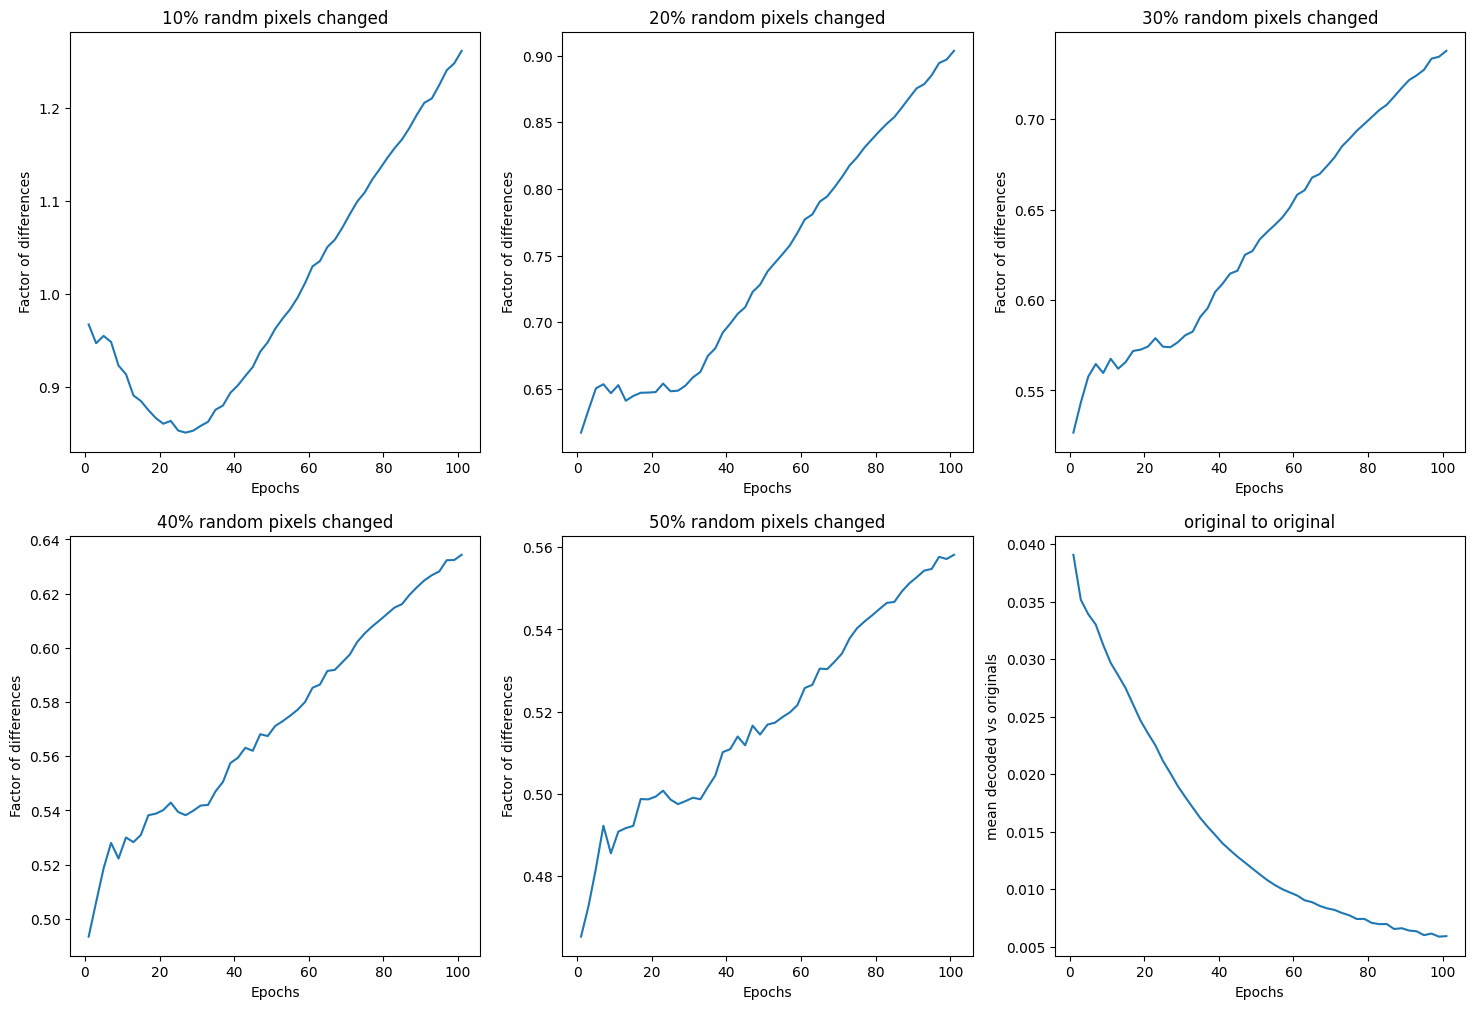

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.plot(epochs, a_rand10)
plt.xlabel('Epochs')
plt.ylabel('Factor of differences')
plt.title('10% randm pixels changed')

plt.subplot(2, 3, 2)
plt.plot(epochs, a_rand20)
plt.xlabel('Epochs')
plt.ylabel('Factor of differences')
plt.title('20% random pixels changed')

plt.subplot(2, 3, 3)
plt.plot(epochs, a_rand30)
plt.xlabel('Epochs')
plt.ylabel('Factor of differences')
plt.title('30% random pixels changed')

plt.subplot(2, 3, 4)
plt.plot(epochs, a_rand40)
plt.xlabel('Epochs')
plt.ylabel('Factor of differences')
plt.title('40% random pixels changed')

plt.subplot(2, 3, 5)
plt.plot(epochs, a_rand50)
plt.xlabel('Epochs')
plt.ylabel('Factor of differences')
plt.title('50% random pixels changed')

plt.subplot(2, 3, 6)
plt.plot(epochs, originals_diffs)
plt.xlabel('Epochs')
plt.ylabel('mean decoded vs originals')
plt.title('original to original')

plt.show()


It seems like somewhere in the beginning of the training ($\approx 25$ epoch) the model is trained enought to know something about digits, but not trained enought to be overfitted. Sure, the reconstruction of original images get better over the training, but the goal of "ignoring" the noise gets worse.

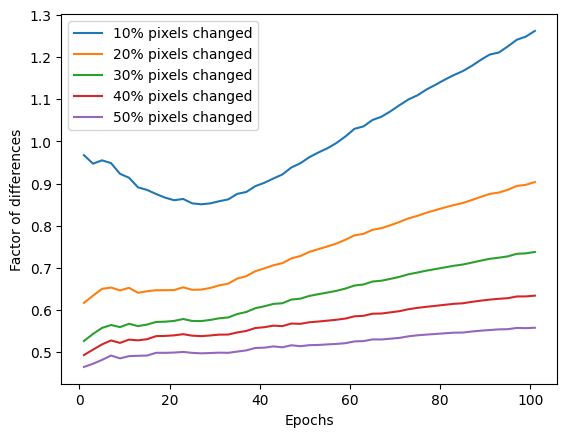

In [8]:
plt.plot(epochs, a_rand10, label='10% pixels changed')
plt.plot(epochs, a_rand20, label='20% pixels changed')
plt.plot(epochs, a_rand30, label='30% pixels changed')
plt.plot(epochs, a_rand40, label='40% pixels changed')
plt.plot(epochs, a_rand50, label='50% pixels changed')
plt.xlabel('Epochs')
plt.ylabel('Factor of differences')
plt.legend()
plt.show()

Autoencoder seems like to repair better the more noised digits. This may be purely a result of the fact that the heavily noisy data is simply different enough from the original data that the result is not very usefull. Here the change of "pure" mean difference between decoded and original:

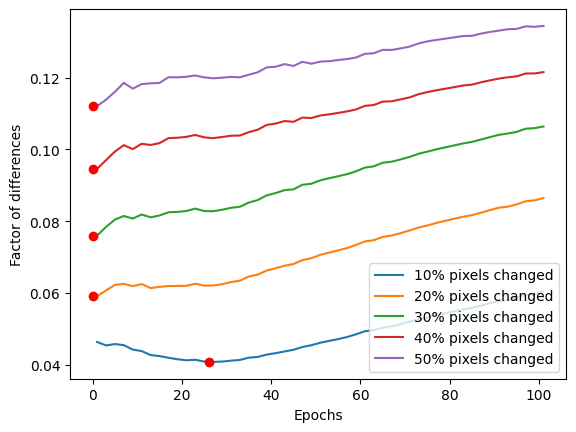

In [9]:
plt.plot(epochs, diff_rand10, label='10% pixels changed')
plt.plot(epochs, diff_rand20, label='20% pixels changed')
plt.plot(epochs, diff_rand30, label='30% pixels changed')
plt.plot(epochs, diff_rand40, label='40% pixels changed')
plt.plot(epochs, diff_rand50, label='50% pixels changed')
plt.plot(2*np.argmin(diff_rand10),np.min(diff_rand10),'ro')
plt.plot(2*np.argmin(diff_rand20),np.min(diff_rand20),'ro')
plt.plot(2*np.argmin(diff_rand30),np.min(diff_rand30),'ro')
plt.plot(2*np.argmin(diff_rand40),np.min(diff_rand40),'ro')
plt.plot(2*np.argmin(diff_rand50),np.min(diff_rand50),'ro')
plt.xlabel('Epochs')
plt.ylabel('Factor of differences')
plt.legend()
plt.show()

The fact is, in most cases it is better to just leave

In [10]:
# prompt: find minima of diff_rand10 and return which position of array is this minima

import numpy as np
minima_index = np.argmin(diff_rand10)
print(f"Minima of diff_rand10 is at index {minima_index}")


Minima of diff_rand10 is at index 13
